
# Code for Master's Thesis: Topic Modeling

## Research Questions

1. Welche Themen können mithilfe von Topic Modeling aus den DHd-Abstracts
der Tagungen zwischen 2014 und 2023 gefunden werden?

*Which topics can be found in the abstracts from DHd-conferences between 2014 and 2023 with Topic Modeling?*

2. Welche Themen kommen häufig gemeinsam in einem Dokument vor und weisen
daher eine hohe Themenähnlichkeit (topic similarity) auf?

*Which topics appear frequently in one abstract and therefore have a high topic similarity?* **Hierarchical Clustering**

3. Wie haben sich die Themenschwerpunkte im Verlauf der Jahre verändert -
welche Trends sind zu erkennen?

*How have the topics been changing throughout the years - which trends are perceptible?* **Mann-Kendall-Test**

4. Welche Entwicklungen sind in Bezug auf die Verwendung verschiedener Forschungsmethoden festzustellen?

*Which developments with regard to the use of different scientific methods are perceptible?*

5. Welche Personen sind besonders häufig mit Abstracts vertreten, in welchen
Autor:innenteams treten sie auf und wie verändern sich diese im Zeitverlauf?

*Which researchers contribute to the conference particularly frequently with abstracts, in which teams do they contribute and how have the teams been changing?*

6. Welche Personencluster sind in Bezug auf die Themenschwerpunkte zu erkennen und wie verändern sich diese?

*Which clusters of researchers can be found with regard to topics and how have the clusters been changing?* **Network Analysis**

### Imports

In [1]:
#Reading in necessary pdf- and xml-files
import zipfile
from bs4 import BeautifulSoup
'''Vermerken: PyPDF2 hat die Zeichen nicht gut erkannt und daher sind einige Wörter herausgefallen'''
import PyPDF2
import fitz
from io import BytesIO

#(pre)processing the files
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
from langdetect import detect
from gensim.models import TfidfModel
import pickle

#LDA
import gensim
import gensim.corpora as corpora
import os

#Evaluation
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt

#Visualisations
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import scipy.cluster.hierarchy as shc

#Hellinger Distance
from gensim.matutils import hellinger
from scipy.spatial.distance import squareform

#Mann-Kendall-Test
import pymannkendall as mk



### Preprocessing function: eliminating non-German texts from corpus

In [2]:
def detect_language(text):
    
    #gets text as input
    lang = detect(text)

    #returns the language tag of detected language
    return lang        

### Preprocessing function: cleaning the texts

In [3]:
def clean_text(text):
        
    # filtering paragraphs from text
    clean = re.sub(r'\n', "", str(text))

    # filtering abbreviations, weblinks, digits and markup from XML      
    abbreviations = ['bspw.', 'sog.', 'vgl.', 'u.a.', 'z.B.', 'bzw.', r'http(.*?) ', r'\d', r'<(.*?)>', 'e.g.', 'also']
    for word in abbreviations:
        clean = re.sub(word, '', clean)

    # filtering punctuation
    punctuation = '''!“()´`¨[]{}\\;:”",<>/.?@#$%^&*_~''' 
    for word in clean:
        if word in punctuation:
            clean = clean.replace(word, "")

    # returns cleaned-up texts
    return clean

### Preprocessing function: removing stopwords and very short/long words

In [4]:
def remove_stopwords(text, language):
    
    # import German stopword list 
    stops_de = set(stopwords.words('german'))
    stops_en = set(stopwords.words('english'))
    
    # convert a document into a list of lowercase tokens, ignoring tokens that are too short (min_len=2) or too long (max_len=15), no deaccentation (by default)
    words = gensim.utils.simple_preprocess(text)
    
    # filter stopwords
    words_filtered = []
    for w in words:
        if language == 'de' and w not in stops_de:
            words_filtered.append(w)
        elif language == 'en' and w not in stops_en:
            words_filtered.append(w)
    
    # return list of words that are NOT stopwords
    return words_filtered


### Preprocessing function: (morpho-syntactic) lemmatization
Hint: 'de_core_news_md' and 'en_core_web_sm' models have to be downloaded via pip beforehand

In [5]:
def lemmatization(texts, language):
    
    # only words tagged as nouns, verbs, adjectives and adverbs should be considered
    allowed_tags = ['NOUN', 'VERB', 'ADJ', 'ADV']

    # disabling parser and ner-tool to accelerate computing 
    nlp_de = spacy.load('de_core_news_md', disable=['parser', 'ner'])
    nlp_en = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        if language == 'de':
            doc = nlp_de(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
        elif language == 'en':
            doc = nlp_en(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_tags:
                    new_text.append(token.lemma_.lower())
            
        # delete all empty sets where the pos-tag was not in allowed list
        if new_text != []:        
            final = " ".join(new_text)
            texts_out.append(final)
    
    # return list of lemmatized words
    return (texts_out)

### Function: Extracting Keywords from XML-File
- extracts tags \<keywords n="topics" scheme="ConfTool"> and \<keywords n="keywords" scheme="ConfTool"> to get keywords of the texts
- checks validity of keywords

In [6]:
def extract_keywords(xmldata):
    
    # finds all tags <keywords n="keywords"> and <keywords n="topics">, removes all tags within
    keywords = str(soup.find_all("keywords", {"n": ("keywords", "topics")}))
    keywords = re.sub("<(.*?)>", "", keywords)
    keywords = keywords.split("\n")

    # filters keywords shorter than 2 letters
    for item in keywords:
        if len(item) <= 2 and item in keywords:
            keywords.remove(item)
            
    # returns list
    return keywords

### Function: Counting number of extracted keywords
- function creates dictionary from the list of keywords
- counts how often each method is used
- returns the dictionary

In [7]:
def count_methods(keywords_year):
    
    methods_dict = {}
    # for each item in keyword list, check if it is alredy in dictionary
    # if not, add and set count to 1, if yes add +1 to count
    for item in keywords_year:
        if item not in methods_dict.keys():
            methods_dict[item] = 1
        else:
            methods_dict[item] += 1
    # sort dictionary according to highest count in the values
    sorted_dict = sorted(methods_dict.items(), key=lambda x: x[1], reverse=True)

    # return the sorted dictionary
    return sorted_dict

### Function: Extracting the author names
Extracts the names of the authors and returns a list of lists containing the names of the single texts' authors

In [8]:
def extract_authors(title_stmt):
    # returns a list of authors for each of the texts
    ''' Evtl so anpassen, dass je Jahr/Zip nochmal eine eigene Liste erstellt wird? '''
    ''' WIE GENAU SOLL DIE NETZWERKANALYSE LAUFEN? '''
    
    all_authors = []
    # navigating to the title statement and finding all tags <author>
    authors = title_stmt.find_all("author")
    fore_and_surnames = []
    
    # extracting the <surname> and <forename> tags and cleaning the outcome from the tags and the brackets
    for element in authors:
        names = element.find_all(['surname', 'forename'])
        names =  re.sub("<(.*?)>", "", str(names))
        names = re.sub("</(.*?)>", "", str(names))
        names = re.sub(r'\]', "", names)
        names = re.sub(r'\[', "", names)
        fore_and_surnames.append(names)
    # all_authors.append(fore_and_surnames)
    
    return fore_and_surnames

### Function: Extracting text from XML-files

In [9]:
def extract_xml_text(soup):
    
    # extract <p> tags from body of xml-document to find the actual text 
    document_body = soup.body
    p_tags = document_body.find_all("p")
    
    # return the text from p-tags
    return p_tags

### Functions: Making bigrams and trigrams

In [10]:
def make_bigrams(texts, bigram):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts, trigram,bigram):
    return ([trigram[bigram[doc]] for doc in texts])

In [11]:
def create_bigrams_trigrams(texts):
   
    bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[texts], threshold=100)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    data_bigrams = make_bigrams(texts, bigram)
    data_bigrams_trigrams = make_trigrams(data_bigrams, trigram, bigram)

    return data_bigrams_trigrams

### Function: Creating bag of words

In [12]:
def create_bow(data_words): 
    
    # mapping the documents' words to a dictionary   
    id2word = corpora.Dictionary(data_words)

    # creating a bag of words by using index of dictionary
    bag_of_words_corpus = []
    for text in data_words:
        new = id2word.doc2bow(text)
        bag_of_words_corpus.append(new)

    # returning id2word-reference as well as bag of word itself, both needed for LDA    
    return id2word, bag_of_words_corpus
    

### Function: TF-IDF weighting

In [13]:
def tf_idf(id2word, texts):
    # simple bag of words for each document, containing tuples with (index, number of appearances of the word in the document)
    corpus = [id2word.doc2bow(text) for text in texts]

    # calculates term frequency (TF) weighted by the inverse document frequency (IDF) for every word/index in the bag of words
    tfidf = TfidfModel(corpus, id2word=id2word)

    # low_value as threshold
    low_value = 0.03
    words  = []
    words_missing_in_tfidf = []

    # for every single bag of words
    for i in range(0, len(corpus)):
        # consider each bow for each document
        bow = corpus[i]
        #low_value_words = [] #reinitialize to be safe. You can skip this.
        
        # for each tuple (index, tfidf-value) in the tf-idf-weighted bag of words, extract index (tfidf_ids)
        tfidf_ids = [id for id, value in tfidf[bow]]
        
        # for each tuple (index, bow-value without tfidf), extract index
        bow_ids = [id for id, value in bow]
        
        # if the value in the (index, tfidf-value) tuple is lower than 0.03, put id into list low_value_words
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        
        drops = low_value_words+words_missing_in_tfidf
        
        # which words will be deleted from the bow?
        for item in drops:
            words.append(id2word[item])
    
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
        
        # add words which indexes are not in low_value_words and not in words_missing_in_tfidf to the new bag of words 
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        
        # new bow is missing certain indexes
        corpus[i] = new_bow
    
    return corpus

## Main Code:

Creating repositories in which variables, models and figures can be saved later

In [14]:
if not os.path.isdir("Variables/"):
    os.mkdir('Variables/')
    print('Created new directory: Variables')
    
if not os.path.isdir('Figures/'):
    os.mkdir('Figures/')
    print('Created new directory: Figures')
    
if not os.path.isdir('Models/'):
    os.mkdir('Models/')
    print('Created new directory: Models')

Reading in zip-files of DHd-conferences where only PDF-files are accessible

In [96]:
filenames_pdf = ['Testfile-pdf.zip']
# filenames_pdf = ['DHd_2014.zip', 'DHd_2015.zip']

# extracting text from pdf-files
all_pdf_texts = []
doc_names = []
for conference_file in filenames_pdf:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    for name in archive.namelist():
        if name[-4:] == '.pdf':
            doc_names_year.append(name)
            pdf_data = BytesIO(archive.read(name))
            # reading each pdf-file in the zip-archive
            with fitz.open(stream=pdf_data, filetype='pdf') as doc:
                text = ''
                for page in doc:
                    text += page.get_text()
                all_pdf_texts.append(text)
    doc_names.append(doc_names_year)


Reading in the zip-files of the DHd-Conferences where XML-files were published

In [97]:
filenames_xml = ['Testfile-xml.zip', 'DHd_2016.zip', 'DHd_2017.zip']
# filenames_xml = ['DHd_2016.zip', 'DHd_2017.zip', 'DHd_2018.zip', 'DHd_2019.zip', 'DHd_2020.zip',
            #  'DHd_2022.zip', 'DHd_2023.zip',]


all_xml_files = []
# read in all zip-folders
for conference_file in filenames_xml:
    archive = zipfile.ZipFile(conference_file, 'r')
    doc_names_year = []
    xml_per_year = []
    # read in all files in the zip-file and check that they are xml-files
    for name in archive.namelist():
        if name[-4:] == '.xml' and not name[-9:] == 'final.xml':
            xml_per_year.append(archive.read(name))
            doc_names_year.append(name)
    all_xml_files.append(xml_per_year)
    # creating a list of all documents' names
    doc_names.append(doc_names_year)

print(doc_names)
filenames = filenames_pdf + filenames_xml
print(filenames)

[['DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/WIENEKE_Lars_The_History_of_Europe_App_A_pipeline_for_Humanist_Machine_Interaction.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/WOLFF_Kerstin_Frauenfragen_um_1900_als_Gegenstand_kontroverser_Kommunikation_im_Umkreis.pdf', 'DHd-Verband-DHd-Abstracts-2014-667e2de/PDF-files/WÜBBENA_Thorsten_Losing_My_Religion_Einsatz_einer_Videoannotationsdatenbank_in_der_kunstgeschichtlichen.pdf'], ['DHd-Verband-DHd-Abstracts-2018-7697044/XML-files/WISSIK_Tanja_ELEXIS___Eine_europäische_Forschungsinfrastrukt.xml', 'DHd-Verband-DHd-Abstracts-2018-7697044/XML-files/WISSIK_Tanja_MeuchelmörderInnen__KindsmörderInnen__DiebInnen.xml', 'DHd-Verband-DHd-Abstracts-2018-7697044/XML-files/ZIRKER_Angelika_Ambiguität_und_Annotation__Herausforderungen.xml', 'DHd-Verband-DHd-Abstracts-2018-7697044/XML-files/ZIRKER_Angelika_TEASys__Kollaborative_digitale_Annotationen_.xml'], ['DHd-Verband-DHd-Abstracts-2016-2fa852e/XML-files/panels-001.xml', 'DHd-Verband-DHd

XML-Files: 

- Extracting the text 
- Extracting the authors of the documents
- Extracting the keywords given in the metadata of the abstracts in order to find the scientific methods used

In [98]:
# Creating dictionary to count how often each method is used

all_xml_texts = []

# contains a list per year, this list contains a list of keywords extracted per text
methods = []
authors = []


for year in all_xml_files:
    keywords_year = []
    authors_year = []
    for doc in year:
        
        soup = BeautifulSoup(doc, 'xml')
        
        """Code for extracting the actual text from xml-files"""
        xml_text = extract_xml_text(soup)
        all_xml_texts.append(xml_text)
        
        
        """Code for extracting the author names"""        
        title_stmt = soup.titleStmt
        authors_in_doc = extract_authors(title_stmt)
        authors_year.append(authors_in_doc) 

    
        
        """Code for extracting the keywords used in xml-files"""        
        keywords = extract_keywords(soup)
        keywords_year = keywords_year + keywords
    
   
    
    ''' gibt pro Jahr die verwendeten Methoden zurück. Hier evtl noch nach richtigen Methoden filtern, denn Text oder Daten sind keine Forschungsmethoden'''
    methods_count = count_methods(keywords_year)
    methods.append(methods_count)
    ''' gibt pro Jahr die Autoren der Texte in Listen pro Text zurück '''
    authors.append(authors_year)
    
# print(len(methods))
# print(len(authors))



Merging the extracted PDF and XML texts for further processing of the textual content:

- Cleaning up
- Removing stopwords depending on the detected language (English or German)
- Lemmatizing the texts depending on the detected language (English or German) --> time-consuming step

In [94]:
# might take some time due to lemmatization!
whole_texts = []
whole_texts = all_pdf_texts + all_xml_texts

list_all_texts = []
for text in whole_texts:
    # detecting language in order to remove the stopwords and lemmatize according to language
    lang = detect_language(str(text))     
    text_item = clean_text(text)
    text_item = remove_stopwords(text_item, lang)
    text_item = lemmatization(text_item, lang)
    
    list_all_texts.append(text_item)
print(list_all_texts)

[['history', 'app', 'pipeline', 'hist', 'machine', 'interaction', 'digital', 'hitie', 'cubrik', 'history', 'app', 'integration', 'expertise', 'machine', 'compion', 'enable', 'new', 'class', 'application', 'significant', 'potential', 'digital', 'hitie', 'far', 'potential', 'remain', 'largely', 'untapped', 'due', 'severe', 'requirement', 'project', 'implementation', 'integration', 'advance', 'algorithm', 'require', 'specialize', 'know', 'final', 'user', 'hitie', 'define', 'unprecedented', 'task', 'method', 'yet', 'fp', 'fund', 'research', 'project', 'cubrik', 'implement', 'integrate', 'research', 'computer', 'science', 'design', 'compion', 'task', 'datum', 'visualization', 'social', 'neere', 'hitie', 'propose', 'presentation', 'cubrik', 'case', 'study', 'demo', 'history', 'application', 'application', 'introduce', 'effective', 'interface', 'access', 'collection', 'historical', 'source', 'discover', 'link', 'entity', 'completion', 'cubrik', 'offer', 'innovative', 'approach', 'enhance', 't

Finding bigrams and trigrams

In [99]:
# creating bigrams and trigrams from lemmatized words
data_bigrams_trigrams = create_bigrams_trigrams(list_all_texts)

Creating id2word and bag of words

In [100]:
# id2word as dictionary where every word is referenced with id
id2word = corpora.Dictionary(data_bigrams_trigrams)

# corpus as dictionary that contains a list of tuples for each document, tuples contain (id, no. of appearances of the word
# some index numbers are missing due to the tf-idf weighting 
corpus = tf_idf(id2word, data_bigrams_trigrams)


Save the variables, so that one does not need to exert the whole script again (too time-consuming)

In [101]:

def save_variable(filename, varname):
    filename = 'Variables/'+filename
    g = open(filename, 'wb')
    pickle.dump(varname, g)
    g.close()

# def open_variable(filename, varname):
#     filename = 'Variables/'+filename
#     varname = open(filename, 'rb')
#     pickle.load(varname)
    
#     return varname
    
   

In [102]:
# writing the files to save the variables


save_variable('corpus.pckl', corpus)
save_variable('id2word.pckl', id2word)
save_variable('list_all_texts.pckl', list_all_texts)
save_variable('data_bigrams_trigrams.pckl', data_bigrams_trigrams)

Opening the variables again for further use

In [103]:
# opening the files for reuse of the variables

# f = open('Variables/corpus.pckl', 'rb')
# corpus = pickle.load(f)
# f.close()

# g = open('Variables/id2word.pckl', 'rb')
# id2word = pickle.load(g)
# g.close()

# h = open('Variables/list_all_texts.pckl', 'rb')
# list_all_texts = pickle.load(h)
# h.close()

# i = open('Variables/data_bigrams_trigrams.pckl', 'rb')
# data_bigrams_trigrams = pickle.load(i)
# i.close()

### Tuning (hyper-)parameters: Find optimal settings for topic number, alpha and beta

**Parameter topic number**

According to https://medium.com/@soorajsubrahmannian/extracting-hidden-topics-in-a-corpus-55b2214fc17d, the best topic number with UMass measure can be found where the coherence draws a plateau in the graph "The number of topics for which the average score plateaus (...) is the (...) spot we are looking for".

**Parameter update_every**

"Number of documents to be iterated through for each update. Set to 0 for batch learning, > 1 for online iterative learning."

**Parameter Alpha**

"Alpha is the parameter, which has the smoothing effect on the topic-document distribution and ensures that the probability of each topic in each document is not 0 throughout the entire inference procedure" (Du, 2022, p. 1). Du's study results indicate that coherence results of models deteriorate with increasing Alpha-parameter, and Du concludes that Alpha of each topic should not be higher than 1 (Du, 2022, p. 2)

In [104]:
def compute_coherence_values(dictionary, corpus, texts, coherence):
    
    # necessary lists (to be returned)
    coherence_values = []
    model_list = []
    topic_coherence_values=[]
    model_names = []
    
    # optimizations for parameters
    # topic_optim = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    # update_optim = [50, 100, 300, 500, 1000, 2000, 3000]
    # alpha_optim = ['symmetric', 'asymmetric', 'auto']
    
    topic_optim = [10]
    update_optim = [300]
    alpha_optim = ['symmetric']

    
    for topics_num in topic_optim:
        for update_interval in update_optim:
            for alpha_value in alpha_optim:
                model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, iterations=6000, num_topics=topics_num,  
                                                      update_every=update_interval, alpha=alpha_value, minimum_probability=1e-8)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
                coherence_values.append(coherencemodel.get_coherence())
                topic_coherence_values.append(coherencemodel.get_coherence_per_topic())
                name = (str(topics_num), str(update_interval), str(alpha_value))
                model_names.append(name)
                name = ''
        

    return model_list, coherence_values, topic_coherence_values, model_names

In [105]:
# initializing random seed to be able to reproduce the results
np.random.seed(1)

# running the function to find the optimal combination of parameters
model_list_cv, coherence_values_cv, topic_coherence_values_cv, model_names = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams, 
                                                                                         coherence="c_v")

In [106]:
print(model_list_cv)
print(coherence_values_cv)
print(model_names)

[0.3537107562877414]
[('10', '300', 'symmetric')]


In [32]:
# saving the variables

# save_variable('model_list_cv.pckl', model_list_cv)
# save_variable('coherence_values_cv.pckl', coherence_values_cv)
# save_variable('topic_coherence_values.pckl', topic_coherence_values_cv)
# save_variable('model_names.pckl', model_names)

In [13]:
# opening the variables

i = open('Variables/model_list_cv.pckl', 'rb')
model_list_cv = pickle.load(i)
i.close()

j = open('Variables/coherence_values_cv.pckl', 'rb')
coherence_values_cv = pickle.load(j)
j.close()

k = open('Variables/topic_coherence_values.pckl', 'rb')
topic_coherence_values = pickle.load(k)
k.close()

l = open('Variables/model_names.pckl', 'rb')
model_names = pickle.load(l)
l.close()

# model_list_cv = open_variable('Variables/model_list_cv.pckl')
# coherence_values_cv = open_variable('Variables/coherence_values_cv.pckl', coherence_values_cv)
# topic_coherence_values_cv = open_variable('Variables/topic_coherence_values_cv.pckl', topic_coherence_values_cv)
# model_names = open_variable('Variables/model_names.pckl', model_names)

Creating a plot in order to make better interpretations

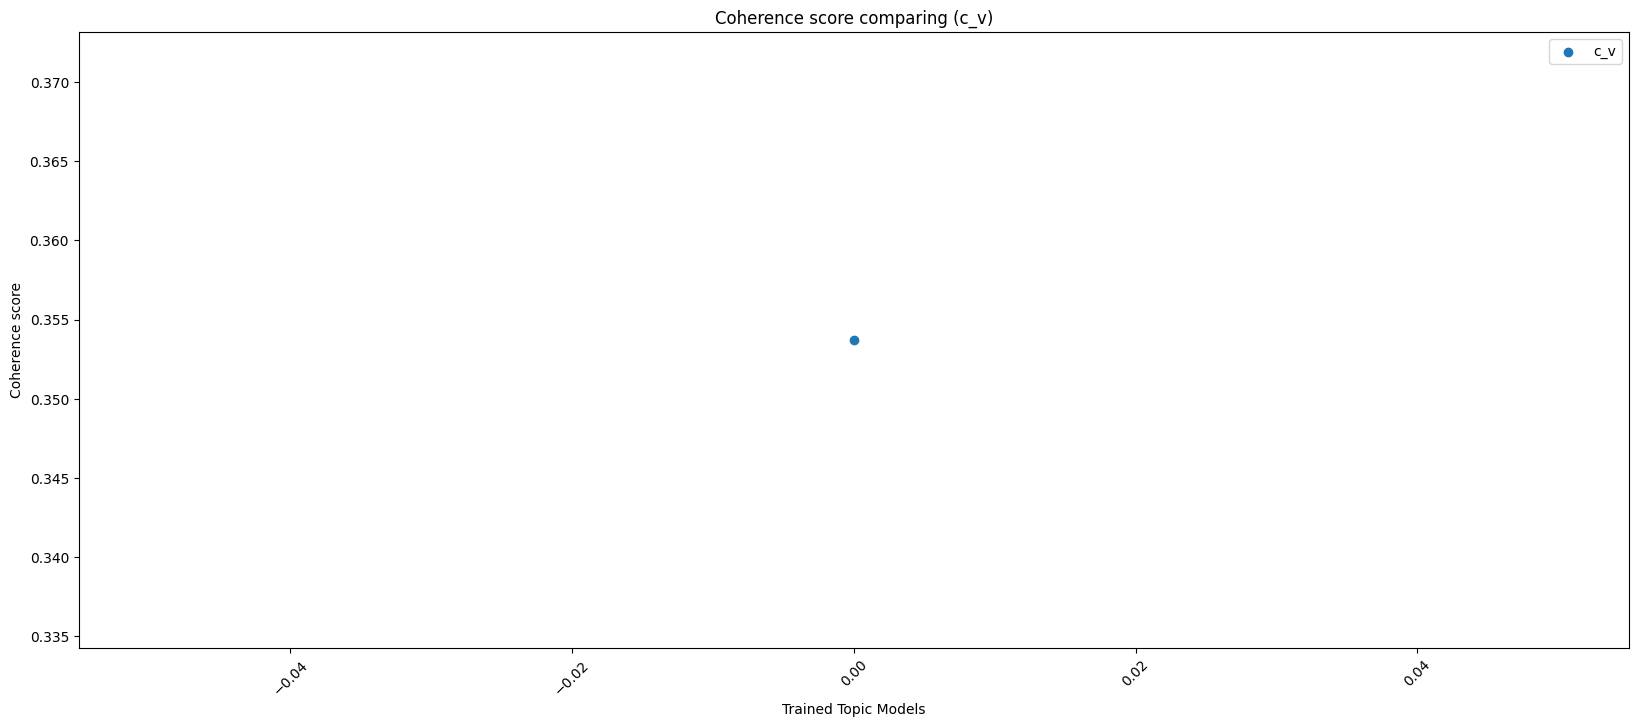

In [107]:
# Customizing and saving the plot
list = []
i = 0
for i in range(len(model_names)):
    list.append(i)
    i += 1

plt.figure(figsize=(20,8))
plt.scatter(list, coherence_values_cv, label ='c_v')
# plt.plot(list, coherence_values_cv, label="c_v")
plt.title("Coherence score comparing (c_v)")
plt.xlabel("Trained Topic Models")
plt.ylabel("Coherence score")
plt.legend()
plt.xticks(rotation=45)

plt.savefig('Figures/Coherence_NumTopics_HyperpOptim.png')
plt.show()


Finding the index with the highest coherence and saving that model for further use

In [108]:
highest_coherence = []
print(coherence_values_cv)
for value in coherence_values_cv:
    if value > 0.3:
        highest_coherence.append(coherence_values_cv.index(value))

for element in highest_coherence:
    print(model_names[element])

        

[0.3537107562877414]
('10', '300', 'symmetric')


In [129]:
index_best_model = coherence_values_cv.index(max(coherence_values_cv))

# Select the model and print the topics
optimal_model = model_list_cv[0]
# optimal_model = model_list_cv[index_best_model]
print(coherence_values_cv[index_best_model])

print('Number of topics in the best model: ', model_list_cv[index_best_model].num_topics)
final_num_topics = model_list_cv[index_best_model].num_topics
# optimal_model.save("Models/optimal_model_n17.model", "w")

0.3537107562877414
Number of topics in the best model:  10


## Research Question 1: Topic Modeling

### Visualisation of final topic modeling with optimal parameters

In [81]:
# model = gensim.models.ldamodel.LdaModel.load("models/optimal_model_n17.model")

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.show(vis, local=False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [22/May/2023 10:39:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/May/2023 10:39:08] code 404, message Not Found
127.0.0.1 - - [22/May/2023 10:39:08] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


### Further analyses with the optimal topic model from above

For all: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

Getting the most frequent words per topic

In [28]:
optimal_model.show_topics()

[(0,
  '0.016*"quellen" + 0.014*"delikt" + 0.014*"definition" + 0.014*"thesaurus" + 0.011*"jahrhundert" + 0.011*"flugblätter" + 0.008*"sko" + 0.008*"tatbeständ" + 0.008*"beschreiben" + 0.008*"hinrichtung"'),
 (1,
  '0.001*"annotation" + 0.001*"ambiguität" + 0.001*"text" + 0.001*"teasys" + 0.001*"daten" + 0.001*"zirker" + 0.001*"bereich" + 0.001*"infrastruktur" + 0.001*"vortrag" + 0.001*"quellen"'),
 (2,
  '0.015*"infrastruktur" + 0.013*"daten" + 0.011*"elexis" + 0.009*"fördern" + 0.009*"partner" + 0.009*"bereich" + 0.007*"wörterbücher" + 0.007*"austausch" + 0.007*"bereits" + 0.006*"europäisch"'),
 (3,
  '0.001*"annotation" + 0.001*"ambiguität" + 0.001*"text" + 0.001*"teasys" + 0.001*"quellen" + 0.001*"daten" + 0.001*"bereich" + 0.001*"erklärenden" + 0.001*"etwa" + 0.001*"textes"'),
 (4,
  '0.011*"hitie" + 0.011*"face" + 0.011*"history" + 0.011*"image" + 0.011*"person" + 0.010*"social" + 0.010*"user" + 0.009*"application" + 0.009*"graph" + 0.008*"research"'),
 (5,
  '0.011*"annotation" 

Showing the probabilities of a certain word to belong to the topics

In [29]:
optimal_model.get_term_topics('lexikalisch')

[(0, 7.899254e-08),
 (1, 1.9513848e-07),
 (2, 6.473504e-08),
 (3, 1.9513848e-07),
 (4, 0.0033760637),
 (5, 5.619549e-08),
 (6, 0.002042657),
 (7, 1.9513756e-07),
 (8, 1.383214e-07),
 (9, 0.006626252)]

## Research Question 2: Hierarchical Clustering and Topic Similarity
Hellinger-Distance:
- range[0, 1] with 0 = completely similar, 1 = completely different
- compares the probability distribution of topics for two documents
- symmetrical measure, i.e. hellinger(a,b) = hellinger(b,a)
- https://radimrehurek.com/gensim/matutils.html#gensim.matutils.hellinger

In [111]:
topics_per_text = []
bow_mann_kendall = []
i = 0

## als Input: Liste von Listen der einzelnen Texte in lemmatisierter/bigramm-Form!

for text in data_bigrams_trigrams:
    #bow-representation of the single text
    bow = optimal_model.id2word.doc2bow(text)
    doc_topics, word_topics, phi_values = optimal_model.get_document_topics(bow, per_word_topics=True)
    #shows the distribution of topics in the single documents
    print(i, doc_topics)
    #saving the topic distribution of each text in a list
    topics_per_text.append(doc_topics)
    i += 1
    

## jetzt: Distanzen von jedem document zu jedem anderen Dokument berechnen und daraus ein Clustering erstellen
## welche Topics sind in den jeweiligen, zueinander nahen Dokumenten sehr präsent?  
hellinger_distances = []
for doc in topics_per_text:
    doc_distances = []
    # print("doc ", doc)
    # comparing the distance between the topic distribution of one text to the distribution of all other texts
    for comparison in topics_per_text:
        # print("comparison ", comparison)
        doc_distances.append(hellinger(doc, comparison))
    # returns list of lists, in which the distance of each document to each other document is saved    
    hellinger_distances.append(doc_distances)   


0 [(0, 0.04865869), (1, 0.00020859636), (2, 0.028933365), (3, 0.00020861617), (4, 0.022890473), (5, 0.8146211), (6, 0.00020858763), (7, 0.03463943), (8, 0.009292844), (9, 0.040338308)]
1 [(0, 0.022737704), (1, 0.88622624), (2, 0.00017691532), (3, 0.00017692581), (4, 0.00017690506), (5, 0.00017691118), (6, 0.08979763), (7, 0.00017691645), (8, 0.00017691345), (9, 0.00017691885)]
2 [(0, 0.015184422), (1, 0.071806446), (2, 0.0001776049), (3, 0.0001776034), (4, 0.00017759044), (5, 0.00017758603), (6, 0.18128657), (7, 0.5283054), (8, 0.00017759652), (9, 0.20252918)]
3 [(0, 0.00052135944), (1, 0.946728), (2, 0.0005213181), (3, 0.0005213382), (4, 0.0005213549), (5, 0.00052131485), (6, 0.0491013), (7, 0.0005213248), (8, 0.0005213383), (9, 0.0005213438)]
4 [(0, 0.0003990267), (1, 0.00039902495), (2, 0.0003989893), (3, 0.0003990078), (4, 0.0003990017), (5, 0.00039898182), (6, 0.15128395), (7, 0.00039901733), (8, 0.1576209), (9, 0.6883021)]
5 [(0, 0.00020182843), (1, 0.00020183662), (2, 0.07176006

Visualization of Hellinger-Distance

C:\Windows\Temp\ipykernel_4956\3012292632.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'))


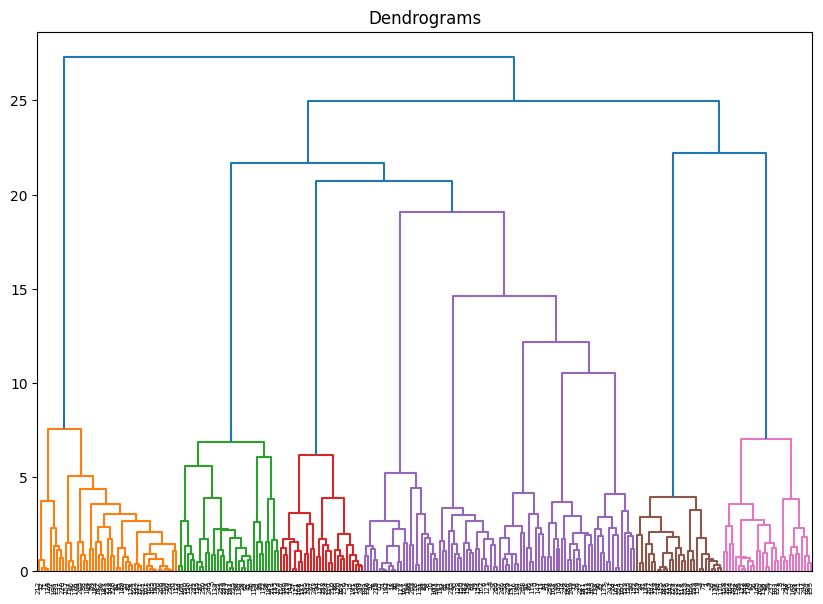

In [112]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(hellinger_distances, method='ward'))

## Research Question 3: Mann-Kendall-Test

https://www.geeksforgeeks.org/how-to-perform-a-mann-kendall-trend-test-in-python/

Mann-Kendall-Test analysiert, ob ein Topic mit fortschreitender Zeit häufiger oder weniger häufig vorkommt

Überlegung: für jedes Jahr und jedes Topic den Durchschnitt dieses Topics berechnen und diesen dann mit MK-Test analysieren

In [131]:
# using the list of names of documents for each year to count how many documents belong to one year
indexes = [0]
for sublist in doc_names:
    indexes.append(len(sublist) + indexes[-1])

# calculating the average probability of a certain topic per year
averages_per_topic_per_year = []
i = 0 
j = 1
while i < int(len(indexes)-1):
    all_probs = []
    for text in topics_per_text[indexes[i]:indexes[j]]:
        probs = []
        for tuple in text:
            topic, probability = tuple
            # extracting only the probability values from the tuple
            probs.append(probability)
        all_probs.append(probs)
    # dividing the sum of all first, second, third... values by the number of values to get the average of all n topics for one year
    averages_per_topic = (np.sum(all_probs, axis=0)/len(all_probs))
    averages_per_topic_per_year.append(averages_per_topic)
    i +=1
    j += 1

# creating a dataframe which shows the average probability of a topic in each year
df = pd.DataFrame(averages_per_topic_per_year, index=filenames).T
print(df)


   Testfile-pdf.zip  Testfile-xml.zip  DHd_2016.zip  DHd_2017.zip
0          0.028860          0.000373      0.103836      0.110429
1          0.319414          0.259275      0.142410      0.160371
2          0.009763          0.018262      0.090704      0.087664
3          0.000188          0.207362      0.103258      0.102014
4          0.007748          0.000373      0.042579      0.060682
5          0.271659          0.000373      0.047638      0.033724
6          0.090431          0.098229      0.262278      0.297000
7          0.187707          0.000373      0.048608      0.026065
8          0.003216          0.039678      0.083541      0.078111
9          0.081015          0.375701      0.075148      0.043942


Visualisation of the development of topic probability averages per year

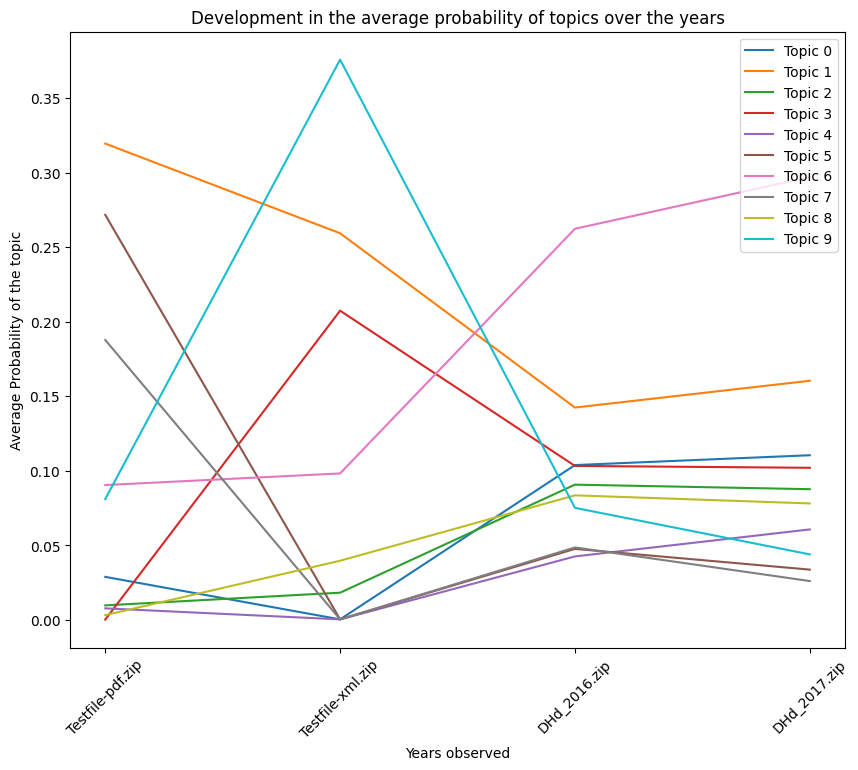

In [132]:
# creating a plot for visualisation
plt.figure(figsize=(10,8))
plt.title("Development in the average probability of topics over the years")
plt.xlabel("Years observed")
plt.ylabel("Average Probability of the topic")

plt.xticks(rotation=45)
''' Here range: number of topics chosen in the final version! '''
for i in range(0, final_num_topics, 1):    
    # creating a line plot showing the development trends of each topic per year
    plt.plot(filenames, df.values[i], label=str('Topic ' + str(i)))
    plt.legend(loc='upper right')
plt.show()   

Mann-Kendall-Test for each topic

In [133]:
for i in range(0, final_num_topics, 1):
    # MK-Test for each topic and its average value
    print(i, mk.original_test(df.values[i]))

0 Mann_Kendall_Test(trend='no trend', h=False, p=0.3081795474670539, z=1.0190493307301363, Tau=0.6666666666666666, s=4.0, var_s=8.666666666666666, slope=0.03233869979158044, intercept=0.01784016494639218)
1 Mann_Kendall_Test(trend='no trend', h=False, p=0.3081795474670539, z=-1.0190493307301363, Tau=-0.6666666666666666, s=-4.0, var_s=8.666666666666666, slope=-0.05657644073168437, intercept=0.2946876734495163)
2 Mann_Kendall_Test(trend='no trend', h=False, p=0.3081795474670539, z=1.0190493307301363, Tau=0.6666666666666666, s=4.0, var_s=8.666666666666666, slope=0.030333797292162977, intercept=0.00746233738027513)
3 Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0, Tau=0.0, s=0.0, var_s=8.666666666666666, slope=0.016348826764442492, intercept=0.07811253461477463)
4 Mann_Kendall_Test(trend='no trend', h=False, p=0.3081795474670539, z=1.0190493307301363, Tau=0.6666666666666666, s=4.0, var_s=8.666666666666666, slope=0.017873585534592472, intercept=-0.0016467249952256714)
5 Mann_Kendal

## Research Question 4: Development and Use of Research Methods

More or less implemented already

## Research Question 5: Analysis of Authors and Teams of Authors

Authors extracted already, how to compare? 

## Research Question 6: Clustering of (Teams of) Authors and certain Research Topics